<a href="https://colab.research.google.com/github/JennEYoon/deep-learning/blob/main/geron-ml3/Copy_of_15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code and solutions to the exercises in chapter 15._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [17]:
import matplotlib.pyplot as plt
# add numpy, pandas
import numpy as np
import pandas as pd

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/rnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [10]:
from pathlib import Path
# modify path for Colab working dir
IMAGES_PATH = Path() / "content" / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [18]:
IMAGES_PATH
# creates folder "content/images/rnn"

PosixPath('content/images/rnn')

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [14]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

### CTA - Ridership - Daily Boarding Totals
This dataset shows systemwide boardings for both bus and rail services provided by CTA, dating back to 2001. Daytypes are as follows: W = Weekday, A = Saturday, U = Sunday/Holiday. See attached readme file for information on how these numbers are calculated.  
**Last Updated**
June 30, 2025

**Warning**: in recent Keras versions, `get_file()` now wraps the extracted directory inside a directory whose name ends with `_extracted`, so the following code checks for that:

In [19]:
filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

In [45]:
# downloaded fresh data, June 2025 last update, starts in 2001.
path ="/content/CTA_-_Ridership_-_Daily_Boarding_Totals_20250803.csv"
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
print(df.tail(10))

           date day_type     bus    rail    total
8876 2025-04-21        W  563978  361549   925527
8877 2025-04-22        W  635896  449995  1085891
8878 2025-04-23        W  620545  448723  1069268
8879 2025-04-24        W  653241  448572  1101813
8880 2025-04-25        W  580882  400327   981209
8881 2025-04-26        A  428587  317347   745934
8882 2025-04-27        U  329874  245932   575806
8883 2025-04-28        W  604201  393731   997932
8884 2025-04-29        W  638090  439903  1077993
8885 2025-04-30        W  632346  435347  1067693


In [46]:
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)


In [47]:
df.head(10)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356
2001-01-07,U,375831,169825
2001-01-08,W,985221,590706
2001-01-09,W,978377,599905


In [48]:
print(df.loc["2019-01-10":])
# during 2021 Covid, bus falls to 1/3 and rail to 1/3/ to 1/5.

           day_type     bus    rail
date                               
2019-01-10        W  747850  690162
2019-01-11        W  763718  679115
2019-01-12        A  382464  325219
2019-01-13        U  301855  250222
2019-01-14        W  756590  705571
...             ...     ...     ...
2025-04-26        A  428587  317347
2025-04-27        U  329874  245932
2025-04-28        W  604201  393731
2025-04-29        W  638090  439903
2025-04-30        W  632346  435347

[2303 rows x 3 columns]


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

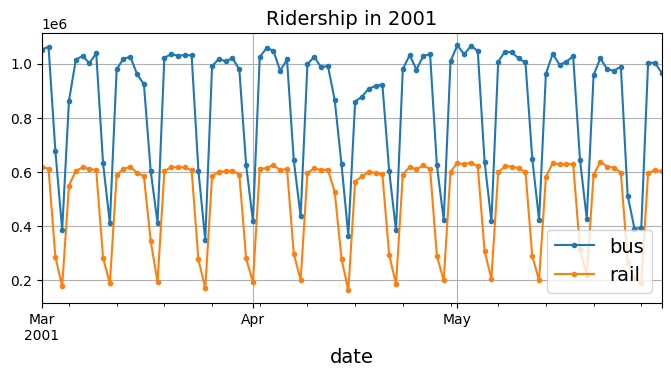

In [51]:
import matplotlib.pyplot as plt

df["2001-03":"2001-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.title("Ridership in 2001")
plt.savefig("ridership_2001.png")  # extra code – saves the figure for the book
plt.show()

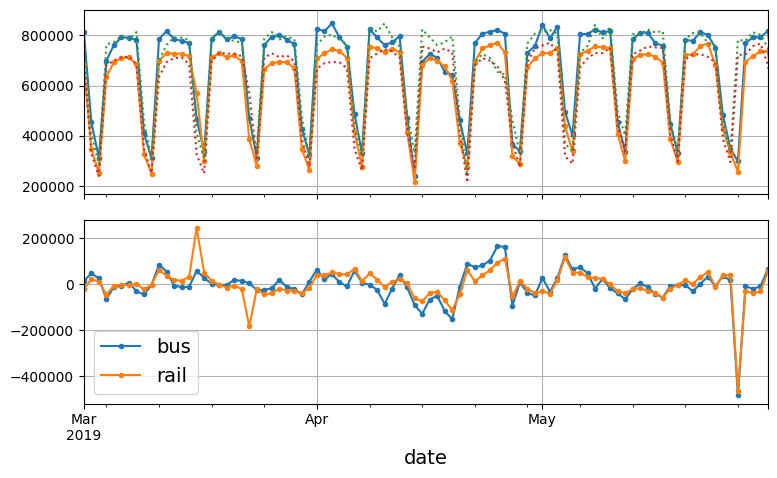

In [52]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [53]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [54]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


Mean absolute percentage error (MAPE):

In [55]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


Now let's look at the yearly seasonality and the long-term trends:

**Warning**: Pandas' API to compute the mean for each month has changed quite a bit, so the code below tries the newest API, and falls back to an older API, and if that also fails, it falls back to the code in the book.

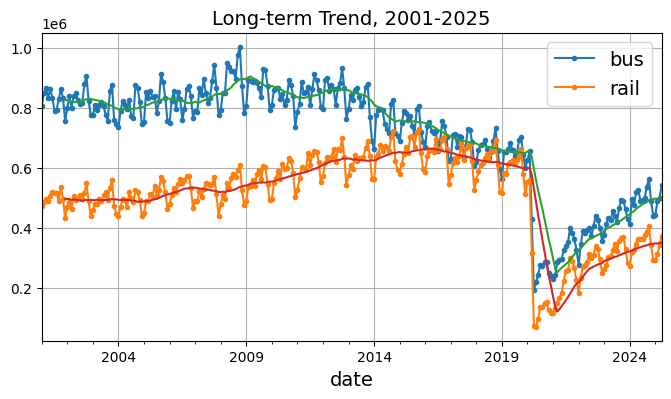

In [58]:
period = slice("2001", "2025")
try:
    df_monthly = df.select_dtypes(include="number").resample('ME').mean()  # compute the mean for each month
    rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
except ValueError as ex:
    try:
        df_monthly = df.select_dtypes(include="number").resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
    except ValueError as ex:
        df_monthly = df.resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.title("Long-term Trend, 2001-2025")
plt.savefig("long_term_trend.png")  # extra code – saves the figure for the book
plt.show()

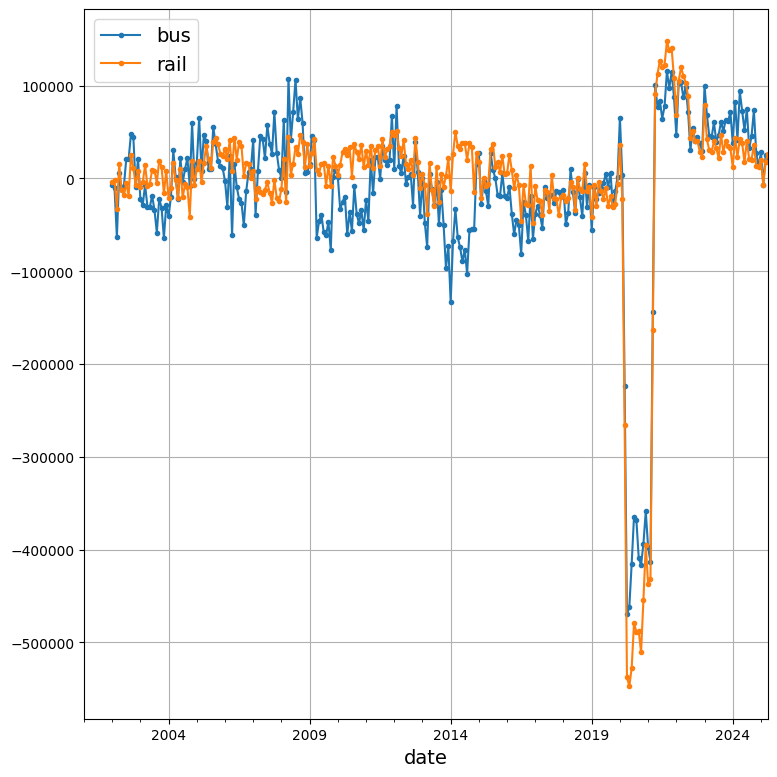

In [63]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 8))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

If running on Colab or Kaggle, install the statsmodels library:

In [64]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [65]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [66]:
y_pred[0]  # ARIMA forecast

/tmp/ipython-input-3394422362.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


np.float64(427758.6262875742)

In [67]:
df["rail"].loc["2019-06-01"]  # target value

np.int64(379044)

In [68]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

np.int64(426932)

**Warning**: Accessing Pandas `Series` by index directly is deprecated, so I replaced `model.forecast()[0]` with `model.forecast().iloc[0]`:

In [69]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [70]:
mae

np.float64(32040.72009292839)

/tmp/ipython-input-2292568549.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")


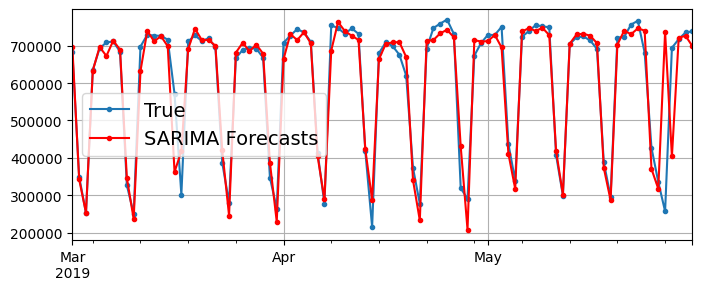

In [71]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

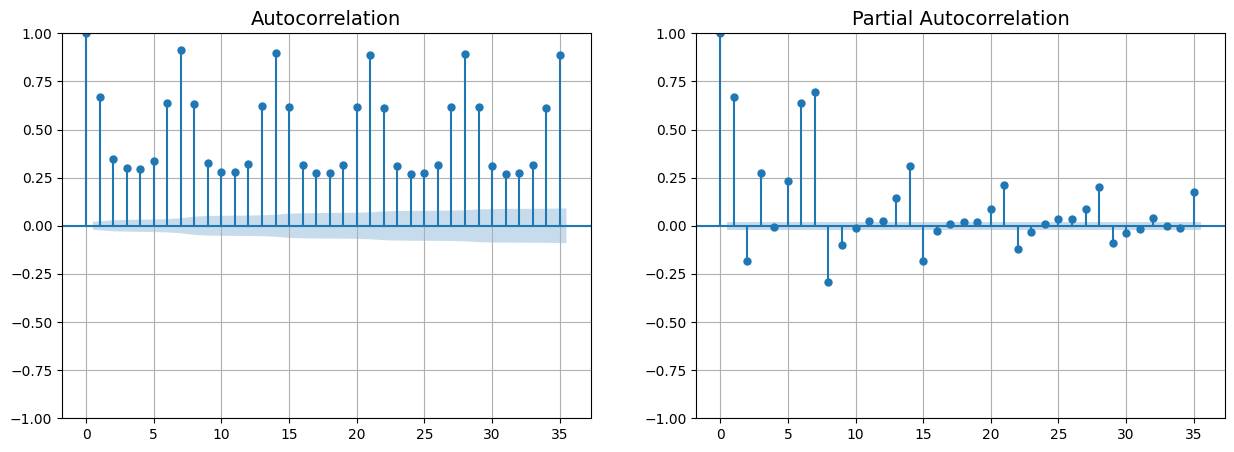

In [72]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [73]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [74]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [75]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [76]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [77]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [78]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":"2019-12"] / 1e6

In [79]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [80]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0884 - mae: 0.3263 - val_loss: 0.0066 - val_mae: 0.0909
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - mae: 0.1162 - val_loss: 0.0054 - val_mae: 0.0816
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mae: 0.1156 - val_loss: 0.0046 - val_mae: 0.0749
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - mae: 0.0970 - val_loss: 0.0041 - val_mae: 0.0705
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0906 - val_loss: 0.0039 - val_mae: 0.0671
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - mae: 0.0915 - val_loss: 0.0058 - val_mae: 0.0837
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - mae: 0.0950 - val_loss: 0.0049 - val_mae: 0.0753
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0838 - val_loss: 0.0034 - val_mae: 0.0610
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

In [81]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - mae: 0.0380


37119.08310651779

## Using a Simple RNN

In [82]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [84]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.7476 - mae: 1.1815 - val_loss: 0.0701 - val_mae: 0.3298
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0632 - mae: 0.3046 - val_loss: 0.0518 - val_mae: 0.2680
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0390 - mae: 0.2084 - val_loss: 0.0202 - val_mae: 0.1367
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0198 - mae: 0.1659 - val_loss: 0.0182 - val_mae: 0.1469
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0191 - mae: 0.1661 - val_loss: 0.0181 - val_mae: 0.1405
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0183 - mae: 0.1620 - val_loss: 0.0174 - val_mae: 0.1416
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0172 - mae: 0.1594 - val_loss: 0.0169 - val_mae: 0.1417
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0178 - mae: 0.1636 - val_loss: 0.0166 - val_mae: 0.1386
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

102789.34985399246

In [85]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [86]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0658 - mae: 0.2736 - val_loss: 0.0049 - val_mae: 0.0803
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mae: 0.0764 - val_loss: 0.0033 - val_mae: 0.0607
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0679 - val_loss: 0.0031 - val_mae: 0.0567
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mae: 0.0625 - val_loss: 0.0024 - val_mae: 0.0469
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0024 - val_mae: 0.0461
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0570 - val_loss: 0.0026 - val_mae: 0.0482
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mae: 0.0555 - val_loss: 0.0021 - val_mae: 0.0380
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mae: 0.0485 - val_loss: 0.0020 - val_mae: 0.0353
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

30129.794031381607

## Deep RNNs

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 2s 32ms/step - loss: 0.0393 - mae: 0.2109 - val_loss: 0.0085 - val_mae: 0.1110
Epoch 2/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0068 - mae: 0.0858 - val_loss: 0.0032 - val_mae: 0.0629
Epoch 3/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0750 - val_loss: 0.0035 - val_mae: 0.0638
Epoch 4/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0048 - mae: 0.0678 - val_loss: 0.0021 - val_mae: 0.0429
Epoch 5/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0043 - mae: 0.0606 - val_loss: 0.0020 - val_mae: 0.0408
Epoch 6/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0042 - mae: 0.0591 - val_loss: 0.0027 - val_mae: 0.0502
Epoch 7/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0045 - mae: 0.0635 - val_loss: 0.0025 - val_mae: 0.0469
Epoch 8/500
33/33 [==============================] - 1s 24ms/step - loss: 0.

31211.024150252342

## Multivariate time series

**Warning**: in recent Pandas versions, `get_dummies()` returns booleans instead of floats, so I added `dtype=float` to ensure we get floats.

In [87]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode the day type

In [92]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":"2019-12"]

In [93]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [94]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [95]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0331 - mae: 0.1866 - val_loss: 0.0111 - val_mae: 0.1398
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0683 - val_loss: 0.0061 - val_mae: 0.0982
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0689 - val_loss: 0.0017 - val_mae: 0.0486
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mae: 0.0470 - val_loss: 9.2691e-04 - val_mae: 0.0318
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0389 - val_loss: 7.5226e-04 - val_mae: 0.0279
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0373 - val_loss: 0.0012 - val_mae: 0.0393
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0370 - val_loss: 0.0013 - val_mae: 0.0428
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 0.0457 - val_loss: 7.2247e-04 - val_mae: 0.0278
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

21982.986479997635

In [96]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0604 - mae: 0.2717 - val_loss: 0.0017 - val_mae: 0.0462
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0597 - val_loss: 0.0015 - val_mae: 0.0414
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0511 - val_loss: 0.0024 - val_mae: 0.0576
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mae: 0.0503 - val_loss: 0.0012 - val_mae: 0.0391
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mae: 0.0460 - val_loss: 0.0015 - val_mae: 0.0441
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0451 - val_loss: 0.0011 - val_mae: 0.0374
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0456 - val_loss: 0.0011 - val_mae: 0.0346
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 0.0432 - val_loss: 0.0012 - val_mae: 0.0383
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.

26720.90008854866

In [97]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

np.float64(43441.63157894738)

In [98]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.MeanAbsoluteError()(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
bus 28239
rail 25202


## Forecasting Several Steps Ahead

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

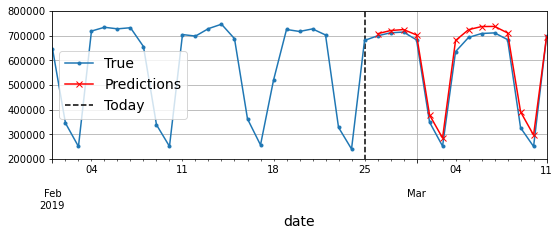

In [ ]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [ ]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.1250 - mae: 0.3791 - val_loss: 0.0287 - val_mae: 0.1935
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0191 - mae: 0.1613 - val_loss: 0.0136 - val_mae: 0.1289
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0131 - mae: 0.1303 - val_loss: 0.0102 - val_mae: 0.1113
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0108 - mae: 0.1164 - val_loss: 0.0083 - val_mae: 0.1009
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0093 - mae: 0.1068 - val_loss: 0.0071 - val_mae: 0.0931
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0083 - mae: 0.0996 - val_loss: 0.0061 - val_mae: 0.0862
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0076 - mae: 0.0941 - val_loss: 0.0055 - val_mae: 0.0811
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0072 - 

35017.29667186737

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [102]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(
        lambda S: (S[:, 0], S[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [103]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [104]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     33/Unknown 4s 43ms/step - loss: 0.1257 - mae: 0.3660

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.1239 - mae: 0.3628 - val_loss: 0.0187 - val_mae: 0.1478
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0141 - mae: 0.1297 - val_loss: 0.0105 - val_mae: 0.1051
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0086 - mae: 0.0982 - val_loss: 0.0072 - val_mae: 0.0835
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - mae: 0.0810 - val_loss: 0.0061 - val_mae: 0.0748
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053 - mae: 0.0722 - val_loss: 0.0055 - val_mae: 0.0703
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0048 - mae: 0.0678 - val_loss: 0.0049 - val_mae: 0.0652
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0047 - mae: 0.0661 - val_loss: 0.0053 - val_mae: 0.0694
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - mae: 0.0637 - val_loss: 0.0049 - val_mae: 0.0648
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 -

46667.33741760254

In [106]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


In [107]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

      1/Unknown 0s 379ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
MAE for +1: 23,431
MAE for +2: 29,684
MAE for +3: 30,195
MAE for +4: 32,519
MAE for +5: 33,077
MAE for +6: 34,008
MAE for +7: 33,787
MAE for +8: 34,908
MAE for +9: 34,325
MAE for +10: 32,897
MAE for +11: 36,747
MAE for +12: 36,853
MAE for +13: 35,254
MAE for +14: 34,881


# Deep RNNs with Layer Norm

In [108]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [109]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [111]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=20)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0100 - mae: 0.1107 - val_loss: 0.0113 - val_mae: 0.1065
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0094 - mae: 0.1063 - val_loss: 0.0107 - val_mae: 0.1011
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - mae: 0.0994 - val_loss: 0.0096 - val_mae: 0.0946
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0944 - val_loss: 0.0087 - val_mae: 0.0895
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0072 - mae: 0.0880 - val_loss: 0.0080 - val_mae: 0.0846
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0067 - mae: 0.0828 - val_loss: 0.0073 - val_mae: 0.0805
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - mae: 0.0774 - val_loss: 0.0065 - val_mae: 0.0747
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0058 - mae: 0.0751 - val_loss: 0.0063 - val_mae: 0.0737
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.005

58290.813118219376

# Extra Material – Creating a Custom RNN Class

The RNN class is not magical. In fact, it's not too hard to implement your own RNN class:

In [112]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [113]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/tmp/ipython-input-3927794187.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [114]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/kernel', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/recurrent_kernel', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/bias', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/gamma', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - loss: 0.1865 - mae: 0.4838 - val_loss: 0.0384 - val_mae: 0.2082
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0336 - mae: 0.1909 - val_loss: 0.0232 - val_mae: 0.1549
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0209 - mae: 0.1446 - val_loss: 0.0174 - val_mae: 0.1331
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0160 - mae: 0.1265 - val_loss: 0.0141 - val_mae: 0.1197
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0129 - mae: 0.1139 - val_loss: 0.0120 - val_mae: 0.1101
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0134 - mae: 0.1162


110115.98259210587

# LSTMs

In [115]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [116]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0892 - mae: 0.3449 - val_loss: 0.0195 - val_mae: 0.1677
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0190 - mae: 0.1696 - val_loss: 0.0184 - val_mae: 0.1478
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0162 - mae: 0.1546 - val_loss: 0.0172 - val_mae: 0.1446
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0154 - mae: 0.1502 - val_loss: 0.0163 - val_mae: 0.1403
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0144 - mae: 0.1460 - val_loss: 0.0155 - val_mae: 0.1355
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0162 - mae: 0.1378


135494.30668354034

# GRUs

In [117]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [118]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0897 - mae: 0.3428 - val_loss: 0.0182 - val_mae: 0.1524
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - mae: 0.1426 - val_loss: 0.0146 - val_mae: 0.1280
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0125 - mae: 0.1261 - val_loss: 0.0132 - val_mae: 0.1220
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0115 - mae: 0.1212 - val_loss: 0.0125 - val_mae: 0.1178
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0109 - mae: 0.1176 - val_loss: 0.0119 - val_mae: 0.1149
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0128 - mae: 0.1183


114934.94361639023

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [119]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [120]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
     31/Unknown 20s 12ms/step - loss: 0.1310 - mae: 0.4149

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.1289 - mae: 0.4106 - val_loss: 0.0204 - val_mae: 0.1586
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0170 - mae: 0.1504 - val_loss: 0.0162 - val_mae: 0.1410
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0139 - mae: 0.1417 - val_loss: 0.0149 - val_mae: 0.1311
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0125 - mae: 0.1317 - val_loss: 0.0136 - val_mae: 0.1231
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0114 - mae: 0.1226 - val_loss: 0.0124 - val_mae: 0.1168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0124 - mae: 0.1168


116770.37924528122

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [121]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [122]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.1381 - mae: 0.4617 - val_loss: 0.0224 - val_mae: 0.1632
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0184 - mae: 0.1621 - val_loss: 0.0188 - val_mae: 0.1529
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0161 - mae: 0.1591 - val_loss: 0.0186 - val_mae: 0.1527
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0158 - mae: 0.1578 - val_loss: 0.0184 - val_mae: 0.1528
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0157 - mae: 0.1576 - val_loss: 0.0183 - val_mae: 0.1521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0183 - mae: 0.1521


152137.33911514282

# Extra Material – Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 26ms/step - loss: 0.0706 - mae: 0.2861 - val_loss: 0.0209 - val_mae: 0.1630
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0137 - mae: 0.1398 - val_loss: 0.0140 - val_mae: 0.1273
Epoch 3/5
31/31 [==============================] - 1s 20ms/step - loss: 0.0104 - mae: 0.1190 - val_loss: 0.0116 - val_mae: 0.1125
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0086 - mae: 0.1048 - val_loss: 0.0096 - val_mae: 0.1020
Epoch 5/5
1/1 [==============================] - 0s 71ms/step - loss: 0.0087 - mae: 0.0953


95349.08086061478

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 8.

1. Here are a few RNN applications:
    * For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
    * For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of _collaborative filtering_ for a recommender system)
    * For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)
2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].
3. To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).
4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t_ + 1 to _t_ + 7).
5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem).
6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. See Figure 15–12.
7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.
8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [123]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [124]:
if "_extracted" in filepath:
    quickdraw_dir = Path(filepath)
else:
    quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [125]:
train_files

['datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00000-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00001-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00002-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00003-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00004-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00005-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00006-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00007-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00008-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00009-of-00010']

In [126]:
eval_files

['datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00000-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00001-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00002-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00003-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00004-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00005-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00006-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00007-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00008-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00009-of-00010']

In [127]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [128]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [129]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [130]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [131]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [132]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [133]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

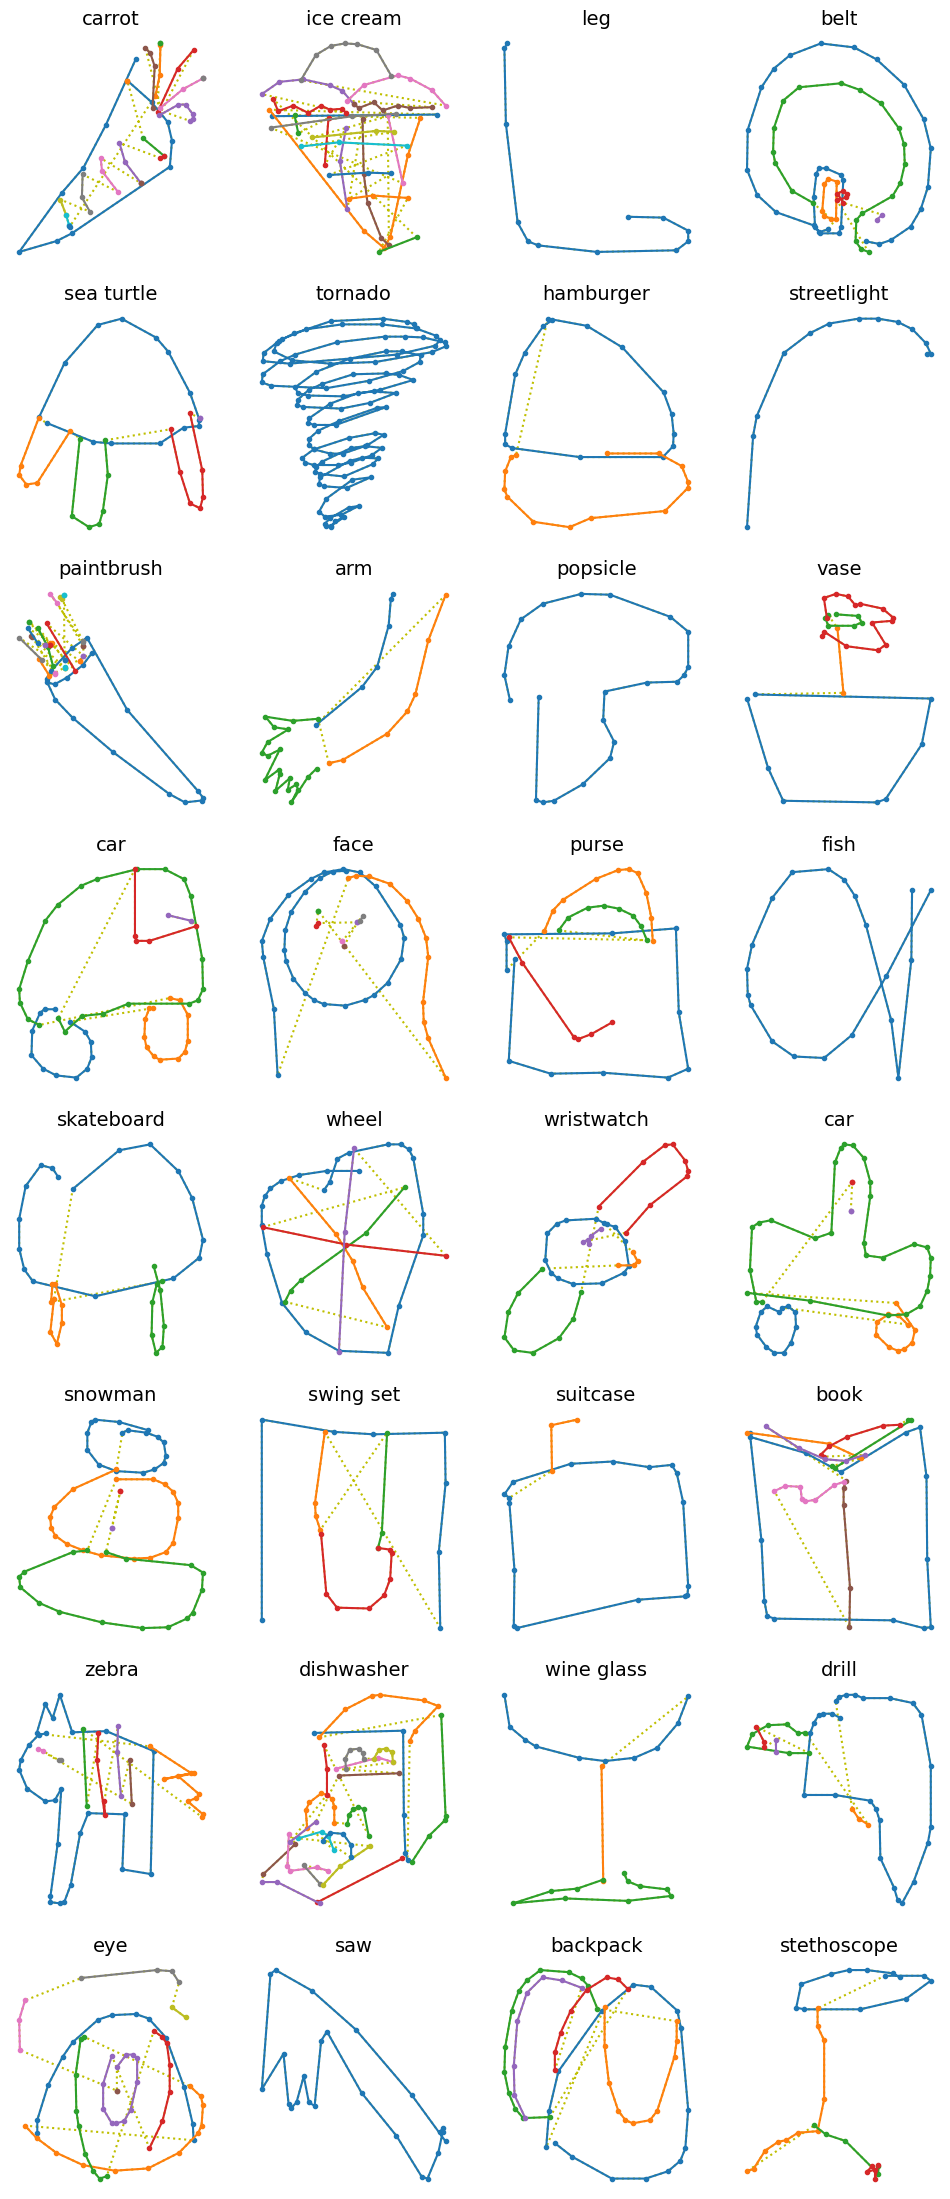

In [135]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

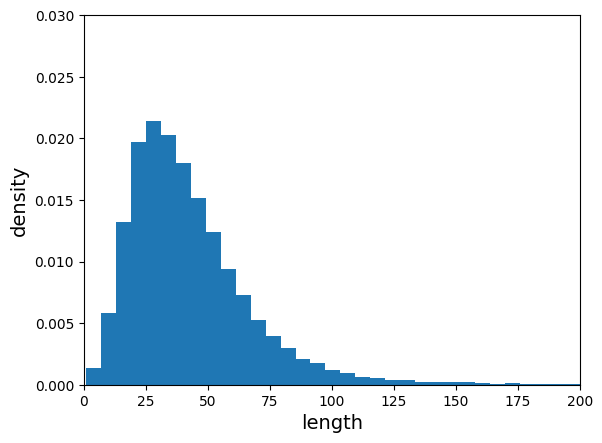

In [136]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [137]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [138]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1058s 10ms/step - accuracy: 0.0788 - loss: 4.8648 - sparse_top_k_categorical_accuracy: 0.2021 - val_accuracy: 0.3175 - val_loss: 3.0489 - val_sparse_top_k_categorical_accuracy: 0.5997
Epoch 2/2
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1102s 10ms/step - accuracy: 0.3470 - loss: 2.8839 - sparse_top_k_categorical_accuracy: 0.6340 - val_accuracy: 0.4247 - val_loss: 2.4613 - val_sparse_top_k_categorical_accuracy: 0.7131


In [139]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step


In [140]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

np.float32(0.60744923)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


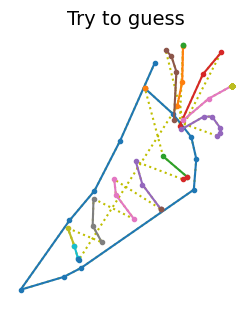

Top-5 predictions:
  1. syringe 13.205%
  2. paintbrush 8.751%
  3. toothpaste 7.164%
  4. pencil 6.192%
  5. marker 5.907%
Answer: carrot


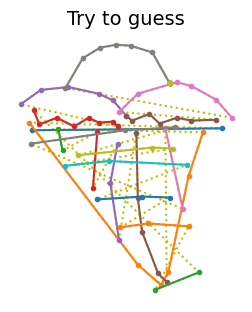

Top-5 predictions:
  1. lighthouse 20.624%
  2. toaster 15.970%
  3. paint can 8.139%
  4. house plant 5.025%
  5. beach 4.610%
Answer: ice cream


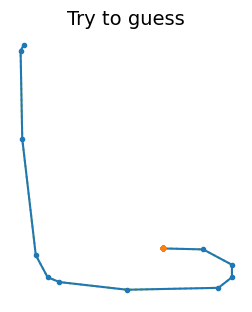

Top-5 predictions:
  1. golf club 39.972%
  2. hockey stick 30.472%
  3. leg 13.751%
  4. foot 7.178%
  5. broom 1.555%
Answer: leg


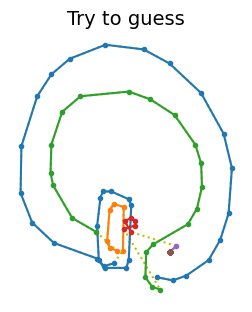

Top-5 predictions:
  1. donut 29.704%
  2. bracelet 26.281%
  3. skull 5.761%
  4. pig 5.282%
  5. lion 2.601%
Answer: belt


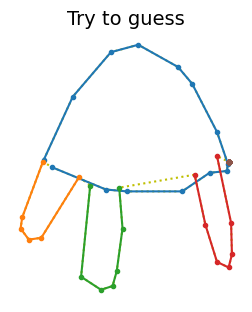

Top-5 predictions:
  1. rhinoceros 14.476%
  2. sea turtle 14.173%
  3. umbrella 9.247%
  4. parachute 7.164%
  5. sheep 5.955%
Answer: sea turtle


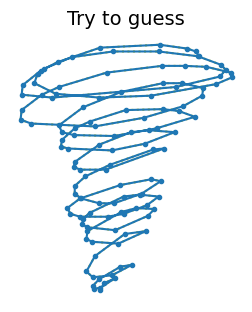

Top-5 predictions:
  1. tornado 62.098%
  2. hurricane 36.627%
  3. squiggle 0.207%
  4. blackberry 0.108%
  5. beard 0.100%
Answer: tornado


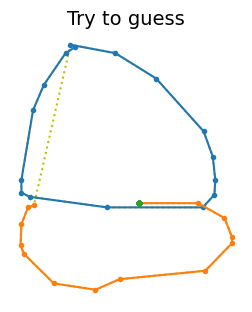

Top-5 predictions:
  1. shovel 13.871%
  2. hamburger 7.862%
  3. hourglass 7.842%
  4. wine glass 5.821%
  5. laptop 5.156%
Answer: hamburger


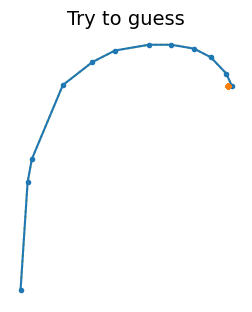

Top-5 predictions:
  1. streetlight 46.949%
  2. finger 10.483%
  3. matches 3.033%
  4. nail 2.811%
  5. knee 2.036%
Answer: streetlight


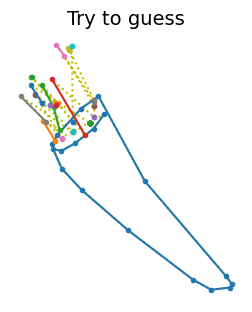

Top-5 predictions:
  1. feather 20.962%
  2. asparagus 12.576%
  3. clarinet 9.387%
  4. carrot 7.932%
  5. toothbrush 6.976%
Answer: paintbrush


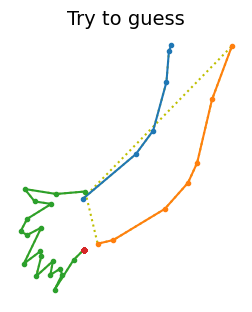

Top-5 predictions:
  1. arm 69.189%
  2. elbow 13.485%
  3. foot 5.523%
  4. rake 2.673%
  5. broom 2.378%
Answer: arm


In [141]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [142]:
model.save("my_sketchrnn.keras")

## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
filepath = tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

117793/117793 [==============================] - 0s 0us/step


In [ ]:
if "_extracted" in filepath:
    jsb_chorales_dir = Path(filepath) / "jsb_chorales"
else:
    jsb_chorales_dir = Path(filepath).with_name("jsb_chorales")

train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d_22 (Conv1D)          (None, None, 32)          352       
                                                                 
 batch_normalization_3 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_23 (Conv1D)          (None, None, 48)          3120      
                                                                 
 batch_normalization_4 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_24 (Conv1D)          (None, None, 64)        

Now we're ready to compile and train the model!

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 25s 208ms/step - loss: 1.8695 - accuracy: 0.5301 - val_loss: 3.7034 - val_accuracy: 0.1226
Epoch 2/20
98/98 [==============================] - 22s 225ms/step - loss: 0.9034 - accuracy: 0.7638 - val_loss: 3.4941 - val_accuracy: 0.1050
Epoch 3/20
98/98 [==============================] - 23s 233ms/step - loss: 0.7523 - accuracy: 0.7916 - val_loss: 3.3243 - val_accuracy: 0.1938
Epoch 4/20
98/98 [==============================] - 23s 232ms/step - loss: 0.6756 - accuracy: 0.8074 - val_loss: 2.5097 - val_accuracy: 0.3022
Epoch 5/20
98/98 [==============================] - 22s 223ms/step - loss: 0.6188 - accuracy: 0.8193 - val_loss: 1.7532 - val_accuracy: 0.4628
Epoch 6/20
98/98 [==============================] - 23s 237ms/step - loss: 0.5788 - accuracy: 0.8280 - val_loss: 1.0323 - val_accuracy: 0.6826
Epoch 7/20
98/98 [==============================] - 25s 256ms/step - loss: 0.5396 - accuracy: 0.8374 - val_loss: 0.7257 - val_accuracy: 0.7910

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [ ]:
model.save("my_bach_model.keras")
model.evaluate(test_set)

34/34 [==============================] - 3s 74ms/step - loss: 0.6631 - accuracy: 0.8164


[0.6630987524986267, 0.8163789510726929]

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")

,day_type,bus,rail
date,,,
2019-01-10,W,747850,690162
2019-01-11,W,763718,679115
2019-01-12,A,382464,325219
2019-01-13,U,301855,250222
2019-01-14,W,756590,705571
2019-01-15,W,783113,720095
2019-01-16,W,800537,728048
2019-01-17,W,800348,734929
2019-01-18,W,776640,700006
